In [1]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence


## Import functions for the experiment : 

from experiment_functions import *

### Taming for Langevin Algorithms

We consider the problem of sampling from a probability measure $ \pi $ having a density on $ \mathbb{R}^d $ known up to a normalizing constant, $ x \mapsto e^{-U(x)}/\int_{\mathbb{R}^d} e^{-U(y)} dy $

The Euler discretization of the Langevin stochastic differential equation (SDE) is known to be unstable in a precise sense, when the potential $U$ is superlinear, i.e. $ \liminf_{\|x\| \to +\infty} \frac{\|\nabla U(x)\|}{\|x\|} = +\infty $. 

In that case, the second order moment of the process $lim_{+\infty} \mathbb{E}[X_n^{2}] = +\infty$ and the sample path $(X_n)_n$ diverges to infinity with a positive probability. This is why we introduce new schemes such as Taming to address this problem. 


------------------------------------------------------------------------------------------------------------------------------------------------------
First example, we consider the following target distribution, called the double well : 

$ \pi(x) = \frac{e^{-U(x)}}{\int_{\mathbb{R}^d} e^{-U(y)} \, dy} \space \propto \space  e^{-U(x)} $ 

We know the target distribution up the normalizing constant and the potential function here is : 

$U(x) = \frac{1}{4} \left\| x \right\|^4 - \frac{1}{2} \left\| x \right\|^2  $

So the potential here is superlinear. We are going to verify that the ULA diverges with a positive probability in this case. 


In [13]:
def grad_double_well(x) : 

    alpha = np.linalg.norm(x, axis = 1) ** 2 - 1

    return alpha[:, np.newaxis] * x

In [14]:
def plot_density_DW(plot_sample = None): 

    x_axis = np.linspace(-5, 5, 200)
    y_axis = np.linspace(-5, 5, 200)

    xx_axis, yy_axis = np.meshgrid(x_axis, y_axis)

    pos = np.dstack((xx_axis, yy_axis))
    
    # Compute the pdf 

    norm = np.linalg.norm(pos, axis = 2)

    pdf = np.exp(-((1/4) * (norm ** 4) - (1/2) * (norm ** 2)))
    
    # Plot the result

    plt.figure(figsize=(8, 8))
    plt.contourf(xx_axis, yy_axis, pdf, levels=50, cmap='Blues', alpha=0.4) 
    ## levels : nombre de niveaux de couleurs ; cmap : choix de la palette de couleurs ; alpha : transparence
    plt.colorbar()
    
    if plot_sample is not None:
        x = plot_sample[:, 0]
        y = plot_sample[:, 1]
        plt.scatter(x, y, alpha=0.5, s = 8, color = 'red')

    plt.title('Double Well density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

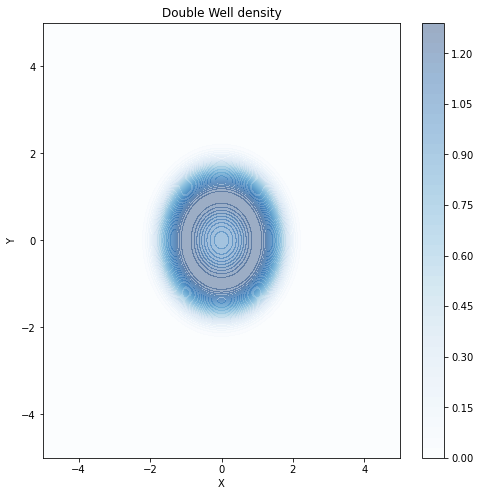

In [15]:
plot_density_DW()

In [49]:
def ULA_double_well(x_init, nb_iter, step) : 

    x = x_init

    dim_sample = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(x.shape[0])

    gradient_term = np.zeros(x.shape[0])

    for i in tqdm(range(nb_iter)):

        # Each iteration we compute the gradient of the target distribution and update the position of the particles
        grad = grad_double_well(x)

        noise =  np.sqrt(2 * step) * np.random.randn(dim_sample, dim_var)

        stochastic_term += np.linalg.norm(noise, axis = 1)

        gradient_term += np.linalg.norm(step * grad, axis = 1) #Size of this vector is nb_particles

        x = x - step * grad + noise

    plot_density_DW(x)

    return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'


    

We introduce the tamed step size to prevent the process from diverging. In the case of the double-well density, we can tame only the superlinear part of the density : 
$G_\gamma(x) = \frac{\|x\|^2 x - x}{1 + \gamma \|x\|^2}$

With this version it seems that it doesn't work so we use the classic formule for the taming coefficients

In [48]:
def ULA_double_well_tamed(x_init, nb_iter, step) : 

    x = x_init

    dim_sample = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(dim_sample)

    gradient_term = np.zeros(dim_sample)

    for i in tqdm(range(nb_iter)):


        ## Version with proposed taming scheme in the paper -> taming only the superlinear part of the gradient
        #norm_sample_squared = np.linalg.norm(x, axis = 1) ** 2
        #tamed_coef = (norm_sample_squared[:, np.newaxis] * x) * (step / (1 + step * norm_sample_squared ** (3/2)))[:, np.newaxis] - x ## Après recalcul, quand on prend la norme du gradient de la partie superlinear c'est plus la norme au cube plutôt qu'au carré..... A verifier
        #tamed_coef = (norm_sample_squared[:, np.newaxis] * x) * (step / (1 + step * norm_sample_squared))[:, np.newaxis] - x

        # Version with classic taming scheme
        grad = grad_double_well(x)
        grad_norm = np.linalg.norm(grad, axis = 1)
        tamed_coef = grad * (step / (1 + step * grad_norm))[:, np.newaxis]
        

        noise =  np.sqrt(2 * step) * np.random.randn(dim_sample, dim_var)

        stochastic_term += np.linalg.norm(noise, axis = 1)

        gradient_term += np.linalg.norm(tamed_coef, axis = 1) #Size of this vector is nb_particles

        x = x - tamed_coef + noise #warning : the sign of the gradient

    plot_density_DW(x)

    return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'


    

In [ ]:
sample_init = np.random.randn(1000, 2)

For different step sizes, we study the behaviour of both approaches : 

This is the plot for classic ULA : 


100%|██████████| 10000/10000 [00:08<00:00, 1203.22it/s]


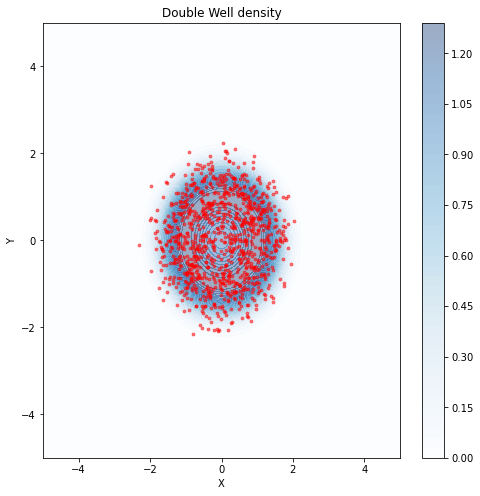

This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:08<00:00, 1149.46it/s]


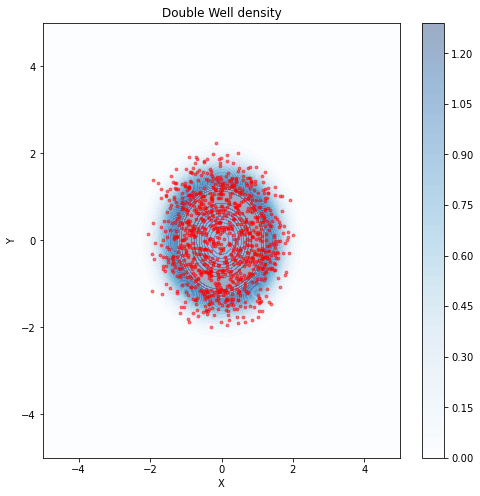

'The magnitude of the Stochastic term is 0.05605650924904491 whereas the magnitude of the gradient term is 0.0013174510292137474'

In [50]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.001)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.001)

This is the plot for classic ULA : 


100%|██████████| 10000/10000 [00:06<00:00, 1452.91it/s]


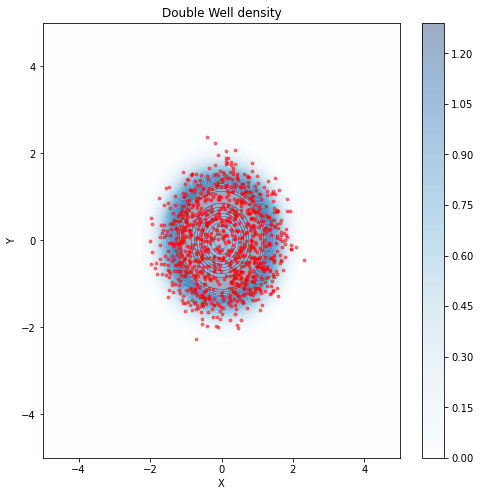

This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:08<00:00, 1209.60it/s]


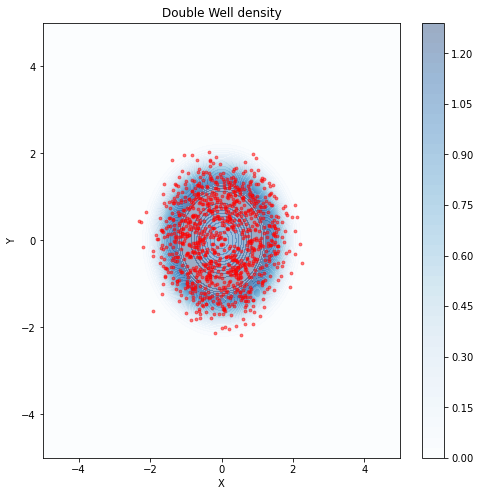

'The magnitude of the Stochastic term is 0.17725212169218824 whereas the magnitude of the gradient term is 0.013075315300306384'

In [51]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.01)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.01)

This is the plot for classic ULA : 


100%|██████████| 10000/10000 [00:07<00:00, 1317.83it/s]


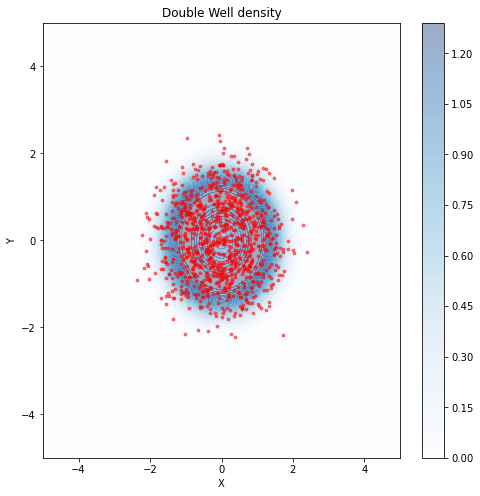

This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:09<00:00, 1076.23it/s]


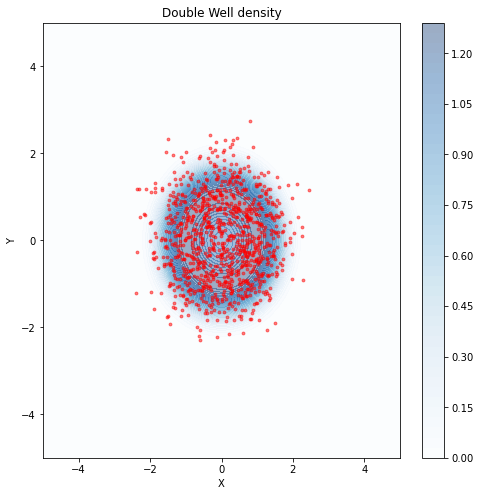

'The magnitude of the Stochastic term is 0.5605904900855798 whereas the magnitude of the gradient term is 0.13053958473853552'

In [52]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.1)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.1)

This is the plot for classic ULA : 


  0%|          | 0/10000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/numpy/linalg/linalg.py:2559: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_52096/725825739.py:5: RuntimeWarning: overflow encountered in multiply
  return alpha[:, np.newaxis] * x
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_52096/2091928910.py:24: RuntimeWarning: invalid value encountered in subtract
  x = x - step * grad + noise
100%|██████████| 10000/10000 [00:05<00:00, 1879.82it/s]


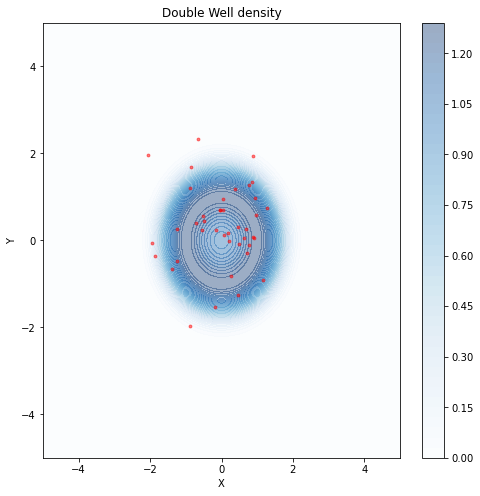

This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:07<00:00, 1276.29it/s]


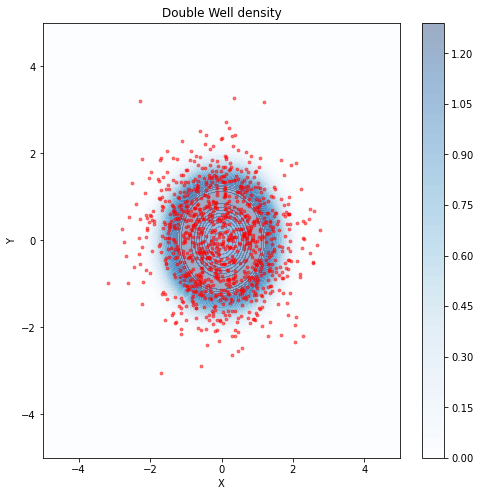

'The magnitude of the Stochastic term is 0.7928393743315059 whereas the magnitude of the gradient term is 0.25277995002419723'

In [53]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.2)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.2)

This is the plot for classic ULA : 


  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_52096/725825739.py:5: RuntimeWarning: overflow encountered in multiply
  return alpha[:, np.newaxis] * x
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_52096/2091928910.py:24: RuntimeWarning: invalid value encountered in subtract
  x = x - step * grad + noise
100%|██████████| 10000/10000 [00:05<00:00, 1691.68it/s]


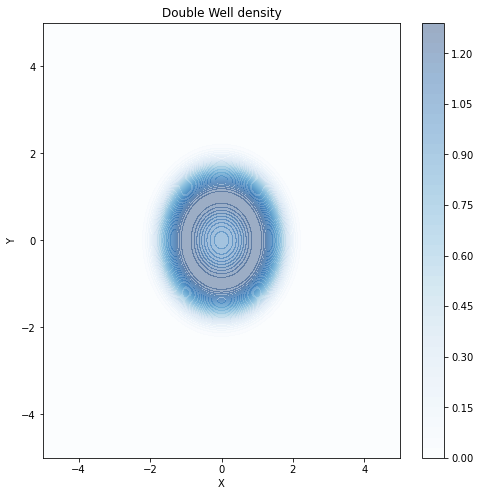

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_52096/2091928910.py:28: RuntimeWarning: Mean of empty slice
  return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'


This is the plot for ULA with taming scheme : 


100%|██████████| 10000/10000 [00:09<00:00, 1099.01it/s]


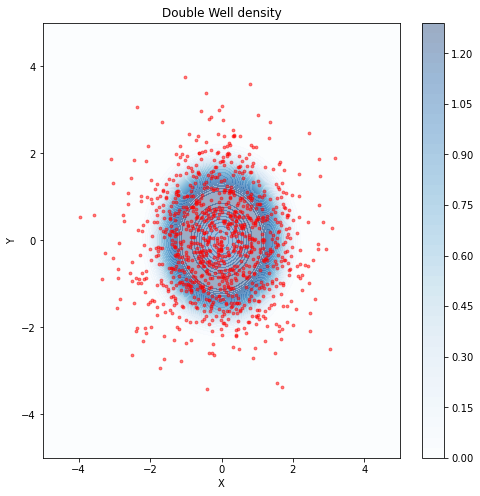

'The magnitude of the Stochastic term is 0.9711104150126525 whereas the magnitude of the gradient term is 0.3610166978582764'

In [54]:
print('This is the plot for classic ULA : ')
ULA_double_well(sample_init, 10000, 0.3)
print('This is the plot for ULA with taming scheme : ')
ULA_double_well_tamed(sample_init, 10000, 0.3)

BROUILLON

In [55]:
def TULAc_dilation(x_init, nb_iter, step, weights, centers, covariances, end_schedule, plot = True, vector_result = False): 

    x = x_init

    sample_size = x.shape[0]

    dim_var = x.shape[1]

    stochastic_term = np.zeros(sample_size)

    gradient_term = np.zeros(sample_size)

    time = np.zeros(sample_size) #Each particle follows its own time-line ? ? 

    step_tab = np.full(sample_size, step)

    for i in tqdm(range(nb_iter)):

        time += step_tab

        schedule = np.minimum(end_schedule, time) / end_schedule

        gamma = 1 / np.sqrt(schedule)

        # Each iteration we compute the gradient of the target distribution and update the position of the particle
        grad = gamma[:, np.newaxis] * grad_multimodal_opti(gamma[:, np.newaxis] * x, weights, centers, covariances)

        grad_update = (step * grad) / (1 + step * np.abs(grad))

        noise =  np.sqrt(2 * step_tab)[:, np.newaxis] * np.random.randn(sample_size, dim_var) #bien terme à terme pour sqrt mais pas besoin car pas constante
        
        stochastic_term += np.linalg.norm(noise, axis = 1)
        
        gradient_term += np.linalg.norm(grad_update, axis = 1) #Vecteur de taille nb_particles 

        x = x + grad_update + noise

    if plot: 

        generate_multimodal(centers, covariances, weights, x)

    if vector_result : 

        print(f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}')

        print(f' Voici le step moyen sur toutes les particles {np.nanmean(time / nb_iter)}, et voici le time moyen auquel on est sur la simu {np.nanmean(time)}')

        return x
    
    print(f' Voici le step moyen sur toutes les particles {np.nanmean(time / nb_iter)}, et voici le time moyen auquel on est sur la simu {np.nanmean(time)}')

    return f'The magnitude of the Stochastic term is {np.nanmean(stochastic_term / nb_iter)} whereas the magnitude of the gradient term is { np.nanmean(gradient_term / nb_iter)}'


In [56]:
#We define the grid

x = np.linspace(-15, 15, 4)
y = np.linspace(-15, 15, 4)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances = np.array([[[3, 0], [0, 3]]]*16)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights = np.ones(16) / 16


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init = np.random.randn(1000, 2)


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:124: RuntimeWarning: divide by zero encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/experiment_functions.py:124: RuntimeWarning: invalid value encountered in true_divide
  gradient = (-1) * (gradient / pdf_tot[:, np.newaxis])
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_52096/3068437931.py:28: RuntimeWarning: invalid value encountered in true_divide
  grad_update = (step * grad) / (1 + step * np.abs(grad))
100%|██████████| 10000/10000 [03:14<00:00, 51.32it/s]


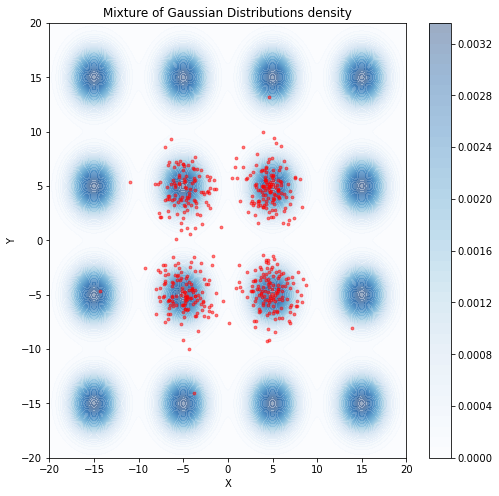

 Voici le step moyen sur toutes les particles 0.00099999999999999, et voici le time moyen auquel on est sur la simu 9.999999999999899


'The magnitude of the Stochastic term is 0.056045526243004726 whereas the magnitude of the gradient term is 0.0011713870577909253'

In [57]:
sample_init = np.random.randn(1000, 2)
TULAc_dilation(sample_init, 10000, 0.001, weights, centers, covariances, 5)

  0%|          | 0/10000 [00:00<?, ?it/s]/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_52096/3068437931.py:28: RuntimeWarning: invalid value encountered in true_divide
  grad_update = (step * grad) / (1 + step * np.abs(grad))
100%|██████████| 10000/10000 [02:59<00:00, 55.79it/s]


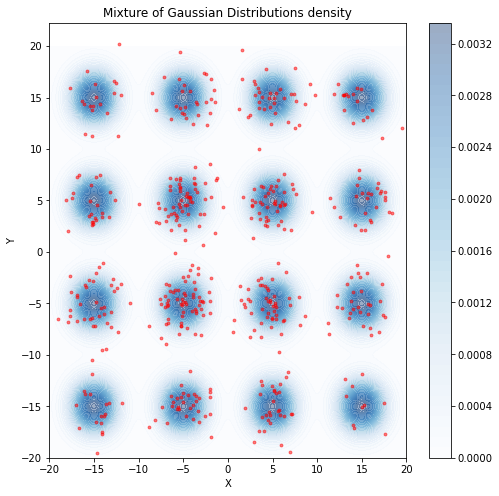

 Voici le step moyen sur toutes les particles 0.010000000000001426, et voici le time moyen auquel on est sur la simu 100.00000000001427


'The magnitude of the Stochastic term is 0.17723092407331859 whereas the magnitude of the gradient term is 0.01056333352202617'

In [58]:
sample_init = np.random.randn(1000, 2)
TULAc_dilation(sample_init, 10000, 0.01, weights, centers, covariances, 50)